In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import tensorflow as tf
import glob
import matplotlib

In [2]:
from collections import defaultdict

In [3]:
root_folder = './isic_logs'

In [6]:
KL_folder = os.path.join(root_folder, 'KL')
##### fixed_scale is the setting where P is a constant function of the batch gradient properties.
##### no lower bound is concerned.
sumKL = {path[:len('KL_fixed_scale') + path[len('KL_fixed_scale'):].index('_')]: os.path.join(KL_folder, path) 
             for path in sorted(os.listdir(KL_folder))}
# for k, v in sumKL.items():
#     print(k, v)
#     print()
print(len(sumKL))

33


In [8]:
white_gaussian_folder = os.path.join(root_folder, 'white_gaussian')
white_gaussian = {
    path[:path.index('conv64')]: os.path.join(white_gaussian_folder, path)
        for path in sorted(os.listdir(white_gaussian_folder))
}

# for k, v in white_gaussian.items():
#     print(k, v)
#     print()
print(len(white_gaussian))

32


In [9]:
no_noise_folder = os.path.join(root_folder, 'no_noise')
no_noise = {
    'no_noise': os.path.join(no_noise_folder, os.listdir(no_noise_folder)[0])
}
print(no_noise)

{'no_noise': './isic_logs/no_noise/no_noiseconv64conv64conv64conv64noise_layerconv64conv64flattenfc641_batchsize128_reg0.002_lr1e-05_dataISIC84_20210520-19:03:17'}


In [10]:
expectation_align_folder = os.path.join(root_folder, 'expectation_align')
expectation_align = {'expectation_align': os.path.join(expectation_align_folder, os.listdir(expectation_align_folder)[0])}
print(expectation_align)

{'expectation_align': './isic_logs/expectation_align/expectation_alignconv64conv64conv64conv64noise_layerconv64conv64flattenfc641_batchsize128_reg0.002_lr1e-05_dataISIC84_20210520-19:01:41'}


In [11]:
# perp_noise = {
#     'perpendicular_noise_lower1.0_upper5.0': 'run-perp_noise_perp_noise_lower1.0_upper5.0128128128128noise_layer1_batchsize65536_reg1_lr0.001^5000w0.0001^12000w2e-05_datafrac0.9_20201010-23_58_27',
#     'perpendicular_noise_lower1.0_upper10.0': 'run-perp_noise_perp_noise_lower1.0_upper10.0128128128128noise_layer1_batchsize65536_reg1_lr0.001^5000w0.0001^12000w2e-05_datafrac0.9_20201010-01_55_03',
#     'perpendicular_noise_lower1.0_upper15.0': 'run-perp_noise_perp_noise_lower1.0_upper15.0128128128128noise_layer1_batchsize65536_reg1_lr0.001^5000w0.0001^12000w2e-05_datafrac0.9_20201010-23_58_27',
# }

In [12]:
dictionary_of_dictionary = {'sumKL': sumKL,
                            'no_noise': no_noise,
                            'white_gaussian': white_gaussian,
                            'expectation_alignment': expectation_align,
#                             'perpendicular_noise': perp_noise,
                            }

In [13]:
def retrieve_all_tb_scalar_trajectories_from_single_path(folder_path):
    tb_event_file_path = glob.glob(pathname=os.path.join(folder_path, 'events*'))[0]
    result = defaultdict(list)
    for e in tf.compat.v1.train.summary_iterator(tb_event_file_path):
        for v in e.summary.value:
            value = tf.make_ndarray(v.tensor)
            if value.shape == ():
                result[v.tag].append((e.step,
                               value.item()))
            else:
                # any histogram information would be an actual tensor at any iteration e.step
                result[v.tag].append((e.step,
                               value))
    for tag_name in result:
        result[tag_name].sort(key=lambda x: x[0])
    return result

In [14]:
from tqdm import tqdm

In [15]:
from multiprocessing import Pool
def f(a):
    return a[0], retrieve_all_tb_scalar_trajectories_from_single_path(a[1])
def retrieve_all_tb_scalar_trajectories_from_many_methods(
        dictionary_of_dictionary):
    result = {}
    for category_name, category_dict in tqdm(dictionary_of_dictionary.items()):
        print(category_name)
        result[category_name] = {}
        with Pool(processes=20) as pool:
            for hyperparameter_instance, all_trajectories in pool.imap_unordered(f, category_dict.items()):
                result[category_name][hyperparameter_instance] = all_trajectories
#         for hyperparameter_instance, path in category_dict.items():
#             print(f'\t{hyperparameter_instance}')
#             result[category_name][hyperparameter_instance] = retrieve_all_tb_scalar_trajectories_from_single_path(path)
    return result

In [16]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [17]:
full_info_dict = retrieve_all_tb_scalar_trajectories_from_many_methods(dictionary_of_dictionary)

  0%|          | 0/4 [00:00<?, ?it/s]

sumKL


 25%|██▌       | 1/4 [07:12<21:37, 432.39s/it]

no_noise


 50%|█████     | 2/4 [09:52<11:41, 350.64s/it]

white_gaussian


 75%|███████▌  | 3/4 [16:01<05:56, 356.19s/it]

expectation_alignment


100%|██████████| 4/4 [18:41<00:00, 280.32s/it]


In [20]:
print(full_info_dict['sumKL'].keys())
print(full_info_dict["white_gaussian"].keys())
print(full_info_dict["expectation_alignment"].keys())
print(full_info_dict["no_noise"].keys())

dict_keys(['KL_fixed_scale1.0', 'KL_fixed_scale25.0', 'KL_fixed_scale1.75', 'KL_fixed_scale30.0', 'KL_fixed_scale20.0', 'KL_fixed_scale0.4', 'KL_fixed_scale3.0', 'KL_fixed_scale2.0', 'KL_fixed_scale0.15', 'KL_fixed_scale2.5', 'KL_fixed_scale1.5', 'KL_fixed_scale0.25', 'KL_fixed_scale0.05', 'KL_fixed_scale0.5', 'KL_fixed_scale35.0', 'KL_fixed_scale0.3', 'KL_fixed_scale10.0', 'KL_fixed_scale0.1', 'KL_fixed_scale0.01', 'KL_fixed_scale0.2', 'KL_fixed_scale4.0', 'KL_fixed_scale5.0', 'KL_fixed_scale45.0', 'KL_fixed_scale50.0', 'KL_fixed_scale55.0', 'KL_fixed_scale40.0', 'KL_fixed_scale6.0', 'KL_fixed_scale8.0', 'KL_fixed_scale70.0', 'KL_fixed_scale7.0', 'KL_fixed_scale9.0', 'KL_fixed_scale90.0', 'KL_fixed_scale80.0'])
dict_keys(['white_gaussian_ratio18.0', 'white_gaussian_ratio0.75', 'white_gaussian_ratio20.0', 'white_gaussian_ratio2.75', 'white_gaussian_ratio13.0', 'white_gaussian_ratio11.0', 'white_gaussian_ratio1.25', 'white_gaussian_ratio15.0', 'white_gaussian_ratio22.0', 'white_gaussian

In [21]:
full_info_dict['sumKL']['KL_fixed_scale90.0']['mask_layer_4_conv64_cosine_leak_batch']

[(1, 0.6337962746620178),
 (2, 0.4117647111415863),
 (3, 0.4270833432674408),
 (4, 0.4211864471435547),
 (5, 0.33799535036087036),
 (6, 0.4979797899723053),
 (7, 0.5281955003738403),
 (8, 0.4010416567325592),
 (9, 0.5182830095291138),
 (10, 0.4396551847457886),
 (11, 0.37457627058029175),
 (12, 0.5526315569877625),
 (13, 0.521212100982666),
 (14, 0.44924813508987427),
 (15, 0.6042372584342957),
 (16, 0.29598507285118103),
 (17, 0.3837535083293915),
 (18, 0.5375939607620239),
 (19, 0.40336135029792786),
 (20, 0.46871310472488403),
 (21, 0.6754237413406372),
 (22, 0.5221238732337952),
 (23, 0.3696969747543335),
 (24, 0.3325563371181488),
 (25, 0.5799409747123718),
 (26, 0.5316091775894165),
 (27, 0.49793511629104614),
 (28, 0.55788654088974),
 (29, 0.5244252681732178),
 (30, 0.5166931748390198),
 (31, 0.5224080085754395),
 (32, 0.5418060421943665),
 (33, 0.4631268382072449),
 (34, 0.48085901141166687),
 (35, 0.5268436670303345),
 (36, 0.5926421284675598),
 (37, 0.3636363744735718),
 (38,

In [22]:
def evaluate_single_run_tradeoff(
        run_name,
        all_trajectories,
        leak_tag_name, # determines which layer's leak AUC to evaluate
        leak_mean_or_max, # use average of |leakAUC - 0.5| over all batches or use max over all batches
        performance_tag_name, # the performance metric (could be 'train_loss', 'test_auc')
        leak_auc_baseline=0.0,# starting from 0.0 or 0.5
    ):
    leak_trajectory = all_trajectories[leak_tag_name]
    
    if leak_mean_or_max == 'mean':
        leak = np.mean(np.absolute(np.array([a[1] for a in leak_trajectory]) - leak_auc_baseline))
    elif leak_mean_or_max == 'max':
#         leak = np.max(np.absolute(np.array([a[1] for a in leak_trajectory]) - 0.5))
#         print(f'max{np.max(np.absolute(np.array([a[1] for a in leak_trajectory]) - 0.5))}')
        leak = np.quantile(a=np.absolute(np.array([a[1] for a in leak_trajectory]) - leak_auc_baseline),
                           q=0.95,
                           interpolation='nearest')
#         print(f'95%{leak}')
#         print(f'5%{np.quantile(a=np.absolute(np.array([a[1] for a in leak_trajectory]) - 0.5),q=0.05,interpolation="nearest")}')
    else:
        assert False, 'unknown option'
    
    performance_trajectory = all_trajectories[performance_tag_name]
    if 'auc' in performance_tag_name or "accu" in performance_tag_name: # auc higher is better
#         performance = np.mean(sorted([a[1] for a in performance_trajectory])[-10:])
        performance = np.amax(np.array([a[1] for a in performance_trajectory]))
    elif 'loss' in performance_tag_name:
        performance = np.amin(np.array([a[1] for a in performance_trajectory]))
    else:
        assert False, 'unknown option'
    
    return (performance, leak, run_name)

In [23]:
def evaluate_one_method_complete_tradeoffs(hyperparameter_to_all_trajectories_dict,
                                           leak_tag_name,
                                           leak_mean_or_max, # use average of |leakAUC - 0.5| over all batches or use max over all batches
                                           performance_tag_name, # the performance metric (could be 'train_loss', 'test_auc')
                                           leak_auc_baseline,
                                          ):
    '''
    evaluate one method's (e.g. sumKL) performance privacy tradeoff at different hyperparameter choices
    return a tuple of two lists:
        privacy: a sorted list of the privacy metric at different hyperparameters
        performance: a matched list of the performance metric
    '''
    tradeoffs = []
    for hyperparameter, all_trajectories in hyperparameter_to_all_trajectories_dict.items():
        result = evaluate_single_run_tradeoff(
            run_name=hyperparameter,
            all_trajectories=all_trajectories,
            leak_tag_name=leak_tag_name,
            leak_mean_or_max=leak_mean_or_max,
            performance_tag_name=performance_tag_name,
            leak_auc_baseline=leak_auc_baseline)
        if result:
            tradeoffs.append(result)
    
    tradeoffs.sort(key=lambda a: a[0])
    performance, privacy, hyperparameter_names = map(list, zip(*tradeoffs))
    return performance, privacy, hyperparameter_names

In [24]:
# def plot_one_method_complete_tradeoffs(
#         hyperparameter_to_all_trajectories_dict,
#         leak_tag_name,
#         leak_mean_or_max, # use average of |leakAUC - 0.5| over all batches or use max over all batches
#         performance_tag_name, # the performance metric (could be 'train_loss', 'test_auc')
#         plot_title,
#         leak_auc_baseline=0.0,
#     ):
#     '''
#     evaluate one method's (e.g. sumKL) performance privacy tradeoff at different hyperparameter choices
#     return a tuple of two lists:
#         privacy: a sorted list of the privacy metric at different hyperparameters
#         performance: a matched list of the performance metric
#     '''
#     for hyperparameter, all_trajectories in hyperparameter_to_all_trajectories_dict.items():

#         tradeoff = evaluate_single_run_tradeoff(
#             run_name=hyperparameter,
#             all_trajectories=all_trajectories,
#             leak_tag_name=leak_tag_name,
#             leak_mean_or_max=leak_mean_or_max,
#             performance_tag_name=performance_tag_name,
#             leak_auc_baseline=leak_auc_baseline)
#         if tradeoff:
#             plt.plot([tradeoff[0]], [tradeoff[1]], 'o', label=hyperparameter)

#     if leak_auc_start <= 0.01:
#         plt.ylabel(r'{} leak_auc'.format(leak_mean_or_max))
#     else:
#         plt.ylabel(r'{} |leak_auc - 0.5|'.format(leak_mean_or_max))
#     plt.xlabel(r'{}'.format(performance_tag_name))
#     plt.title(plot_title)

In [25]:
def plot_different_methods_tradeoff_curves(
        multiple_methods_info_dict,
        leak_tag_name,
        leak_mean_or_max,
        performance_tag_name,
        plot_title,
        y_label,
        leak_auc_baseline=0.0,
        ):

    for method_name in multiple_methods_info_dict:

        performance_list, privacy_list, hyperparameter_list = \
            evaluate_one_method_complete_tradeoffs(
                hyperparameter_to_all_trajectories_dict=multiple_methods_info_dict[method_name],
                leak_tag_name=leak_tag_name,
                leak_mean_or_max=leak_mean_or_max,
                performance_tag_name=performance_tag_name,
                leak_auc_baseline=leak_auc_baseline)

        plt.plot(performance_list, privacy_list, 'o', label=method_name)
    plt.legend()
    if leak_auc_baseline == 0.0:
        plt.ylabel(f'{y_label}')
    else:
        plt.ylabel(f'|{y_label} - {leak_auc_baseline}|')
    plt.xlabel(f'{performance_tag_name}')
    plt.title(plot_title)

In [26]:
evaluate_single_run_tradeoff(
        run_name='no_noise',
        all_trajectories=full_info_dict['no_noise']['no_noise'],
        leak_tag_name='mask_layer_4_conv64_norm_leak_batch', # determines which layer's leak AUC to evaluate
        leak_mean_or_max='max', # use average of |leakAUC - 0.5| over all batches or use max over all batches
        performance_tag_name='test_auc', # the performance metric (could be 'train_loss', 'test_auc',
        leak_auc_baseline=0.5,
    )

(0.8501735925674438, 0.5, 'no_noise')

In [27]:
perf, priv, name = evaluate_one_method_complete_tradeoffs(
    hyperparameter_to_all_trajectories_dict=full_info_dict['sumKL'],
    leak_tag_name='mask_layer_4_conv64_norm_leak_batch', # determines which layer's leak AUC to evaluate
    leak_mean_or_max='max', # use average of |leakAUC - 0.5| over all batches or use max over all batches
    performance_tag_name='test_auc', # the performance metric (could be 'train_loss', 'test_auc')
    leak_auc_baseline=0.5,
)
for a,b,c in zip(perf, priv, name):
    print(a,b,c)

0.8056215047836304 0.17711862921714783 KL_fixed_scale90.0
0.8084220886230469 0.1774425506591797 KL_fixed_scale80.0
0.8093502521514893 0.17796608805656433 KL_fixed_scale50.0
0.8100282549858093 0.17754468321800232 KL_fixed_scale70.0
0.810560941696167 0.1775919795036316 KL_fixed_scale55.0
0.8113922476768494 0.17796611785888672 KL_fixed_scale45.0
0.8115173578262329 0.1779448688030243 KL_fixed_scale40.0
0.8135310411453247 0.1784660816192627 KL_fixed_scale35.0
0.8138377666473389 0.1781250238418579 KL_fixed_scale30.0
0.8141525387763977 0.1781609058380127 KL_fixed_scale25.0
0.8163962364196777 0.1790560483932495 KL_fixed_scale20.0
0.8185028433799744 0.18333333730697632 KL_fixed_scale10.0
0.818874180316925 0.18428093194961548 KL_fixed_scale9.0
0.8200242519378662 0.18534082174301147 KL_fixed_scale8.0
0.8206577301025391 0.18686869740486145 KL_fixed_scale7.0
0.8222438097000122 0.18919968605041504 KL_fixed_scale6.0
0.8242292404174805 0.19303423166275024 KL_fixed_scale5.0
0.8256739377975464 0.2084745

In [28]:
perf, priv, name = evaluate_one_method_complete_tradeoffs(
    hyperparameter_to_all_trajectories_dict=full_info_dict['white_gaussian'],
    leak_tag_name='mask_layer_4_conv64_norm_leak_batch', # determines which layer's leak AUC to evaluate
    leak_mean_or_max='max', # use average of |leakAUC - 0.5| over all batches or use max over all batches
    performance_tag_name='test_auc', # the performance metric (could be 'train_loss', 'test_auc')
    leak_auc_baseline=0.5,
)
for a,b,c in zip(perf, priv, name):
    print(a,b,c)

0.802183210849762 0.1780133843421936 white_gaussian_ratio27.0
0.8043744564056396 0.1784660816192627 white_gaussian_ratio25.0
0.8049596548080444 0.17881357669830322 white_gaussian_ratio24.0
0.8082123398780823 0.17881354689598083 white_gaussian_ratio22.0
0.8098788857460022 0.17880487442016602 white_gaussian_ratio23.0
0.8107990026473999 0.17896175384521484 white_gaussian_ratio21.0
0.8143018484115601 0.17959868907928467 white_gaussian_ratio20.0
0.81459641456604 0.18023598194122314 white_gaussian_ratio19.0
0.8177481889724731 0.18031609058380127 white_gaussian_ratio18.0
0.817998468875885 0.18122786283493042 white_gaussian_ratio17.0
0.8221993446350098 0.18428093194961548 white_gaussian_ratio15.0
0.8277844786643982 0.18859648704528809 white_gaussian_ratio13.0
0.8331800103187561 0.19765883684158325 white_gaussian_ratio11.0
0.8402380347251892 0.21623563766479492 white_gaussian_ratio9.0
0.8447619080543518 0.2544642686843872 white_gaussian_ratio7.0
0.8475221395492554 0.37187498807907104 white_gaus

In [29]:
evaluate_single_run_tradeoff(
        run_name='no_noise',
        all_trajectories=full_info_dict['no_noise']['no_noise'],
        leak_tag_name='mask_layer_4_conv64_norm_leak_batch', # determines which layer's leak AUC to evaluate
        leak_mean_or_max='max', # use average of |leakAUC - 0.5| over all batches or use max over all batches
        performance_tag_name='test_auc', # the performance metric (could be 'train_loss', 'test_auc')
        leak_auc_baseline=0.5,
    )

(0.8501735925674438, 0.5, 'no_noise')

In [30]:
# plot_one_method_complete_tradeoffs(
#         hyperparameter_to_all_trajectories_dict=full_info_dict['sumKL'],
#         leak_tag_name='mask_layer_4_conv64_cosine_leak_batch', # determines which layer's leak AUC to evaluate
#         leak_mean_or_max='max', # use average of |leakAUC - 0.5| over all batches or use max over all batches
#         performance_tag_name='test_auc', # the performance metric (could be 'train_loss', 'test_auc')
#         plot_title='sumKL'
#     )

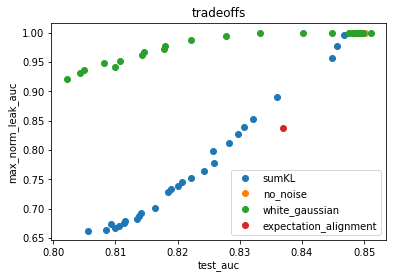

In [31]:
plot_different_methods_tradeoff_curves(
    multiple_methods_info_dict=full_info_dict,
        leak_tag_name='mask_layer_4_conv64_cosine_leak_batch', # determines which layer's leak AUC to evaluate
        leak_mean_or_max='max', # use average of |leakAUC - 0.5| over all batches or use max over all batches
        performance_tag_name='test_auc', # the performance metric (could be 'train_loss', 'test_auc'),
        plot_title='tradeoffs',
        y_label='max_norm_leak_auc',
        leak_auc_baseline=0.0,
    )
# 'deep_mask_layer_3_unit_128_norm_leak_batch'

Generate the leak AUC progression statistics

In [32]:
def plot(info, label):
    l, = plt.plot([x[0] for x in info], [x[1] for x in info], label=label)
    return l

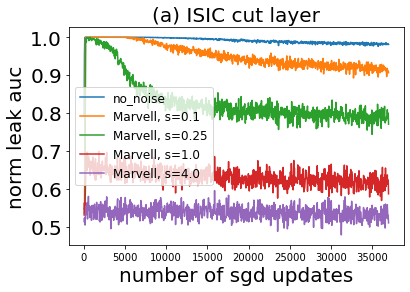

In [33]:
legend_handles = []
# import matplotlib
matplotlib.rcParams["legend.framealpha"] = 0.8

legend_handles.append(plot(full_info_dict['no_noise']['no_noise']['mask_layer_4_conv64_norm_leak'],
                           label='no_noise'))
legend_handles.append(plot(full_info_dict['sumKL']['KL_fixed_scale0.1']['mask_layer_4_conv64_norm_leak'],
                           label='Marvell, s=0.1'))
legend_handles.append(plot(full_info_dict['sumKL']['KL_fixed_scale0.25']['mask_layer_4_conv64_norm_leak'],
                           label='Marvell, s=0.25'))
# legend_handles.append(plot(full_info_dict['sumKL']['KL_fixed_scale0.5']['mask_layer_4_conv64_norm_leak'],
#                            label='Marvell, s=0.5'))
legend_handles.append(plot(full_info_dict['sumKL']['KL_fixed_scale1.0']['mask_layer_4_conv64_norm_leak'],
                           label='Marvell, s=1.0'))
# legend_handles.append(plot(full_info_dict['sumKL']['KL_fixed_scale2.0']['mask_layer_4_conv64_norm_leak'],
#                            label='Marvell, s=2.0'))
legend_handles.append(plot(full_info_dict['sumKL']['KL_fixed_scale4.0']['mask_layer_4_conv64_norm_leak'],
                           label='Marvell, s=4.0'))


plt.legend(handles=legend_handles, fontsize=12)
plt.title('(a) ISIC cut layer', fontsize=20)
plt.xlabel('number of sgd updates', fontsize=20)
plt.ylabel('norm leak auc', fontsize=20)
plt.yticks(fontsize=20)
# plt.subplots_adjust(left=0.12, 
#             bottom=0.13,
#             top=0.92,
#             right=0.99)
plt.savefig('a_isic_norm_leak_auc_cut_layer.pdf', bbox_inches='tight', pad_inches=0.0)

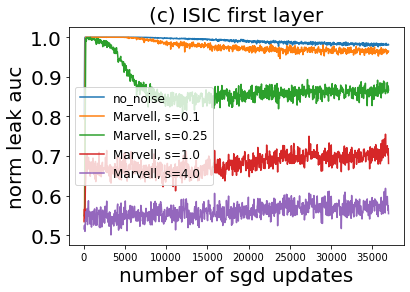

In [66]:
legend_handles = []
# import matplotlib
matplotlib.rcParams["legend.framealpha"] = 0.8

legend_handles.append(plot(full_info_dict['no_noise']['no_noise']['mask_layer_1_conv64_norm_leak'],
                           label='no_noise'))
legend_handles.append(plot(full_info_dict['sumKL']['KL_fixed_scale0.1']['mask_layer_1_conv64_norm_leak'],
                           label='Marvell, s=0.1'))
legend_handles.append(plot(full_info_dict['sumKL']['KL_fixed_scale0.25']['mask_layer_1_conv64_norm_leak'],
                           label='Marvell, s=0.25'))
# legend_handles.append(plot(full_info_dict['sumKL']['KL_fixed_scale0.5']['mask_layer_4_conv64_norm_leak'],
#                            label='Marvell, s=0.5'))
legend_handles.append(plot(full_info_dict['sumKL']['KL_fixed_scale1.0']['mask_layer_1_conv64_norm_leak'],
                           label='Marvell, s=1.0'))
# legend_handles.append(plot(full_info_dict['sumKL']['KL_fixed_scale2.0']['mask_layer_4_conv64_norm_leak'],
#                            label='Marvell, s=2.0'))
legend_handles.append(plot(full_info_dict['sumKL']['KL_fixed_scale4.0']['mask_layer_1_conv64_norm_leak'],
                           label='Marvell, s=4.0'))


plt.legend(handles=legend_handles, fontsize=12)
plt.title('(c) ISIC first layer', fontsize=20)
plt.xlabel('number of sgd updates', fontsize=20)
plt.ylabel('norm leak auc', fontsize=20)
plt.yticks(fontsize=20)
# plt.subplots_adjust(left=0.12, 
#             bottom=0.13,
#             top=0.92,
#             right=0.99)
plt.savefig('c_isic_norm_leak_auc_first_layer.pdf', bbox_inches='tight', pad_inches=0.0)

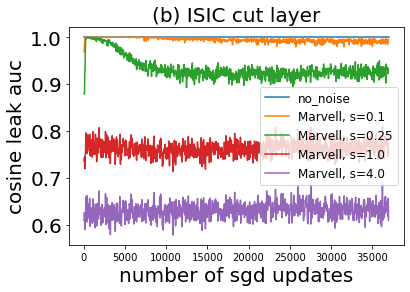

In [67]:
legend_handles = []
# import matplotlib
matplotlib.rcParams["legend.framealpha"] = 0.8

legend_handles.append(plot(full_info_dict['no_noise']['no_noise']['mask_layer_4_conv64_cosine_leak'],
                           label='no_noise'))
legend_handles.append(plot(full_info_dict['sumKL']['KL_fixed_scale0.1']['mask_layer_4_conv64_cosine_leak'],
                           label='Marvell, s=0.1'))
legend_handles.append(plot(full_info_dict['sumKL']['KL_fixed_scale0.25']['mask_layer_4_conv64_cosine_leak'],
                           label='Marvell, s=0.25'))
# legend_handles.append(plot(full_info_dict['sumKL']['KL_fixed_scale0.5']['mask_layer_4_conv64_norm_leak'],
#                            label='Marvell, s=0.5'))
legend_handles.append(plot(full_info_dict['sumKL']['KL_fixed_scale1.0']['mask_layer_4_conv64_cosine_leak'],
                           label='Marvell, s=1.0'))
# legend_handles.append(plot(full_info_dict['sumKL']['KL_fixed_scale2.0']['mask_layer_4_conv64_norm_leak'],
#                            label='Marvell, s=2.0'))
legend_handles.append(plot(full_info_dict['sumKL']['KL_fixed_scale4.0']['mask_layer_4_conv64_cosine_leak'],
                           label='Marvell, s=4.0'))


plt.legend(handles=legend_handles, fontsize=12)
plt.title('(b) ISIC cut layer', fontsize=20)
plt.xlabel('number of sgd updates', fontsize=20)
plt.ylabel('cosine leak auc', fontsize=20)
plt.yticks(fontsize=20)
# plt.subplots_adjust(left=0.12, 
#             bottom=0.13,
#             top=0.92,
#             right=0.99)
plt.savefig('b_isic_cosine_leak_auc_cut_layer.pdf', bbox_inches='tight', pad_inches=0.0)

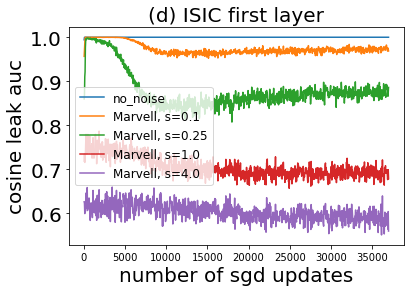

In [68]:
legend_handles = []

matplotlib.rcParams["legend.framealpha"] = 0.8

legend_handles.append(plot(full_info_dict['no_noise']['no_noise']['mask_layer_1_conv64_cosine_leak'],
                           label='no_noise'))
legend_handles.append(plot(full_info_dict['sumKL']['KL_fixed_scale0.1']['mask_layer_1_conv64_cosine_leak'],
                           label='Marvell, s=0.1'))
legend_handles.append(plot(full_info_dict['sumKL']['KL_fixed_scale0.25']['mask_layer_1_conv64_cosine_leak'],
                           label='Marvell, s=0.25'))
# legend_handles.append(plot(full_info_dict['sumKL']['KL_fixed_scale0.5']['mask_layer_4_conv64_norm_leak'],
#                            label='Marvell, s=0.5'))
legend_handles.append(plot(full_info_dict['sumKL']['KL_fixed_scale1.0']['mask_layer_1_conv64_cosine_leak'],
                           label='Marvell, s=1.0'))
# legend_handles.append(plot(full_info_dict['sumKL']['KL_fixed_scale2.0']['mask_layer_4_conv64_norm_leak'],
#                            label='Marvell, s=2.0'))
legend_handles.append(plot(full_info_dict['sumKL']['KL_fixed_scale4.0']['mask_layer_1_conv64_cosine_leak'],
                           label='Marvell, s=4.0'))


plt.legend(handles=legend_handles, fontsize=12)
plt.title('(d) ISIC first layer', fontsize=20)
plt.xlabel('number of sgd updates', fontsize=20)
plt.ylabel('cosine leak auc', fontsize=20)
plt.yticks(fontsize=20) 
# first tune the font size and then tune the margin!
# the actual box edges's location in the entire image
# plt.subplots_adjust(left=0.12, 
#             bottom=0.13,
#             top=0.92,
#             right=0.99)
plt.savefig('d_isic_cosine_leak_auc_first_layer.pdf',bbox_inches='tight', pad_inches=0.0)

In [34]:
# matplotlib.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams['ps.fonttype'] = 42
# matplotlib.rcParams.update({'font.size': 22}) # change fonts size when text is too small to read
from matplotlib.ticker import FormatStrFormatter

def scatter_plot_different_methods_tradeoff_curves(
        multiple_methods_info_dict,
        leak_tag_name,
        leak_mean_or_max,
        performance_tag_name,
        plot_title,
        xlabel,
        ylabel,
        save_file_name,
        leak_auc_baseline=0.0,):
    
    fig, axes = plt.subplots(1, 1, figsize=(12, 10))
    
    for method_name in ['white_gaussian', 'sumKL', 'expectation_alignment', 'no_noise']:#multiple_methods_info_dict:
        performance, privacy, hyper_names = evaluate_one_method_complete_tradeoffs(
            hyperparameter_to_all_trajectories_dict=multiple_methods_info_dict[method_name],
            leak_tag_name=leak_tag_name,
            leak_mean_or_max=leak_mean_or_max,
            leak_auc_baseline=leak_auc_baseline,
            performance_tag_name=performance_tag_name)

        if method_name == 'white_gaussian':
            axes.scatter(performance, privacy, c="#cc8374", label="iso", marker = "^", s = 360.0)
        elif method_name == 'no_noise':
            axes.scatter(performance, privacy, c="#FFC222", label="no_noise", marker = "s", s = 360.0)
        elif method_name == 'sumKL':
            axes.scatter(performance, privacy, c="#33FF82", label="Marvell", marker = "o", s = 360.0)
        elif method_name == 'expectation_alignment':
            axes.scatter(performance, privacy, c="#33A8FF", label="max_norm", marker = "*", s = 360.0)
       
#     axes.legend(loc="lower right")
    axes.legend(fontsize=36)
    font_size = 42
    axes.grid(b = True, linestyle="dashed")
    axes.set_xlabel(xlabel, fontsize=font_size)
    axes.set_ylabel(ylabel, fontsize=font_size)
    axes.tick_params(axis="x", labelsize=font_size - 12)
    axes.tick_params(axis="y", labelsize=font_size)
    axes.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

#     if leak_auc_start <= 0.01:
#         plt.xlabel(r'{} leak_auc'.format(leak_mean_or_max))
#     else:
#         plt.xlabel(r'{} |leak_auc - 0.5|'.format(leak_mean_or_max))
#     plt.ylabel(r'{}'.format(performance_tag_name))
    plt.title(plot_title, fontsize=42)
    fig.savefig(save_file_name, bbox_inches='tight', pad_inches=0.0)

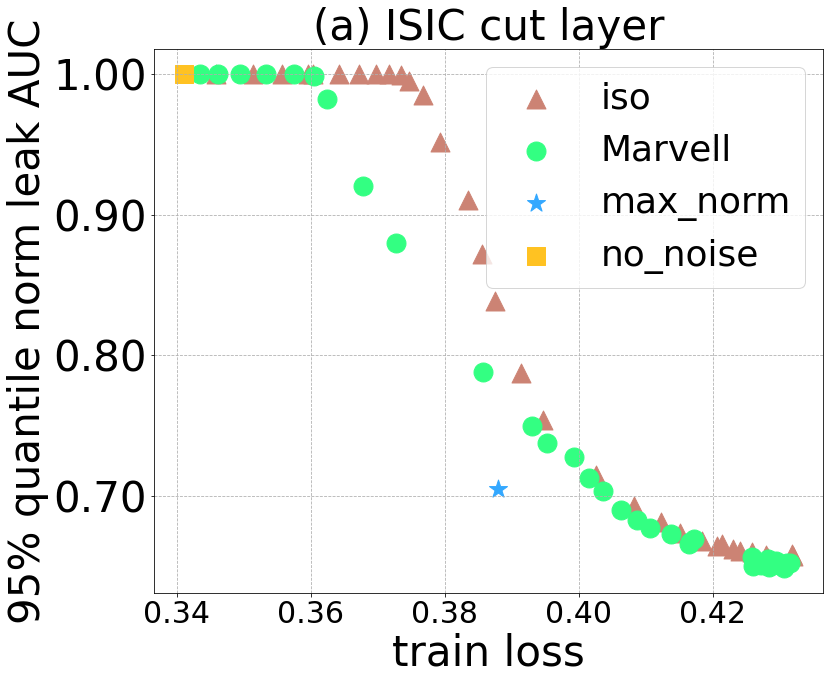

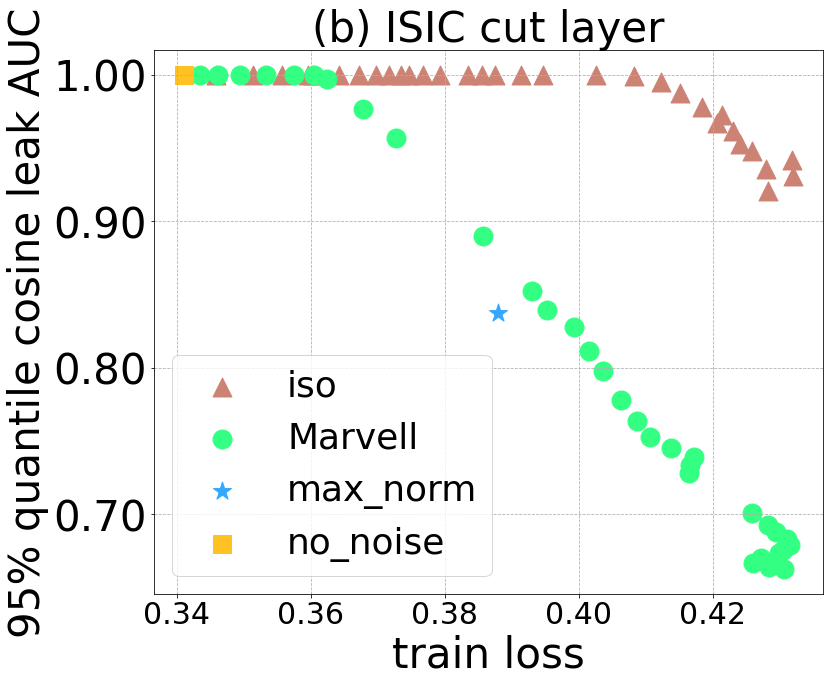

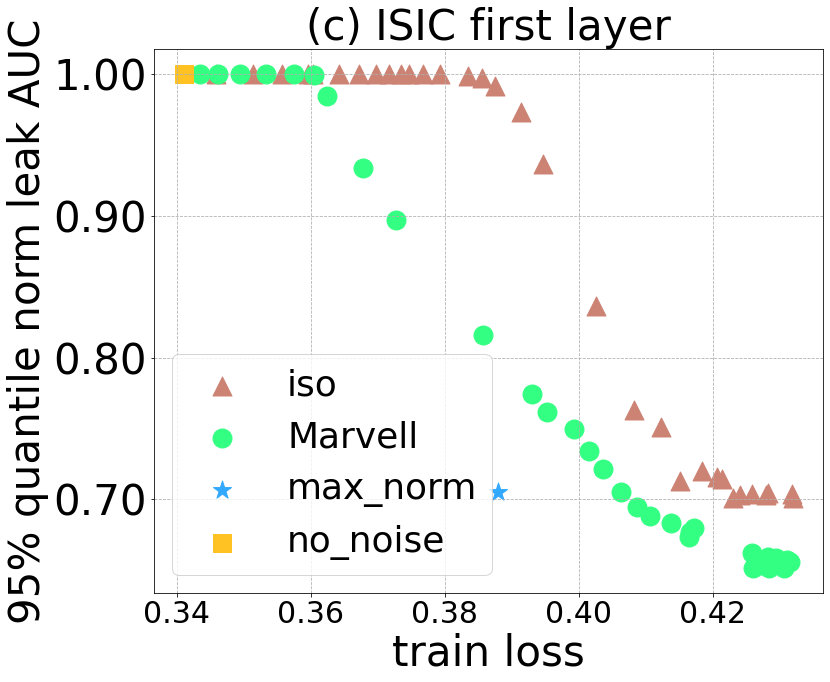

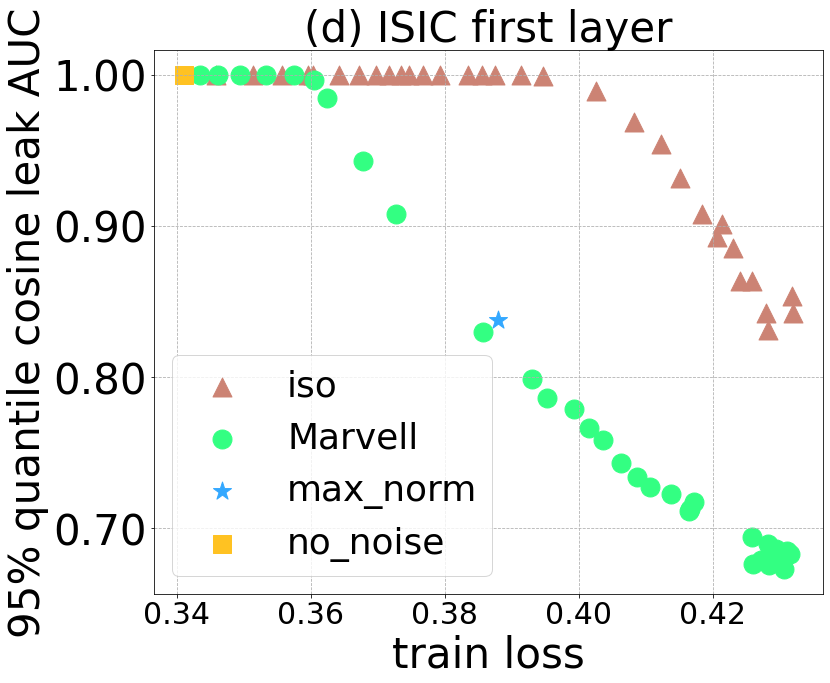

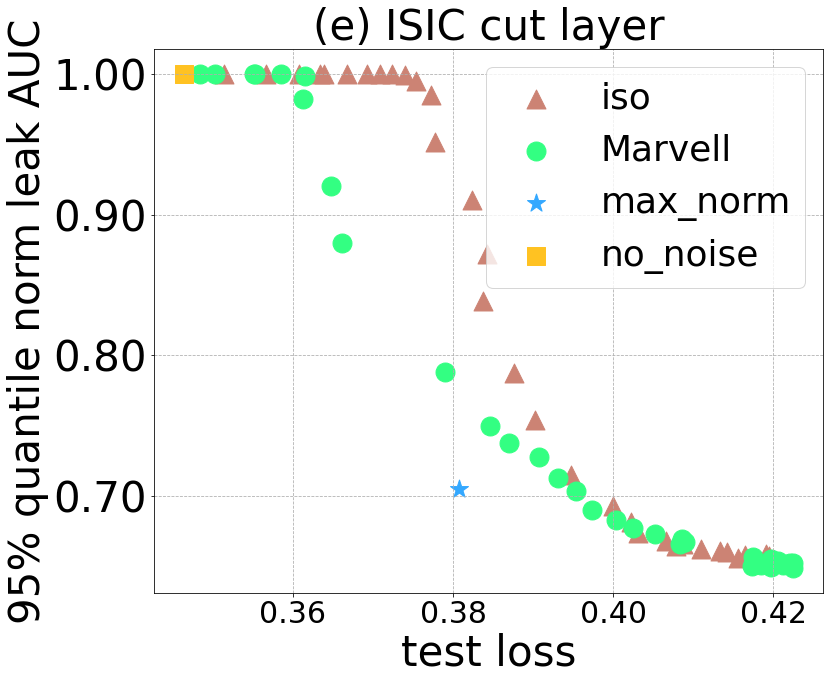

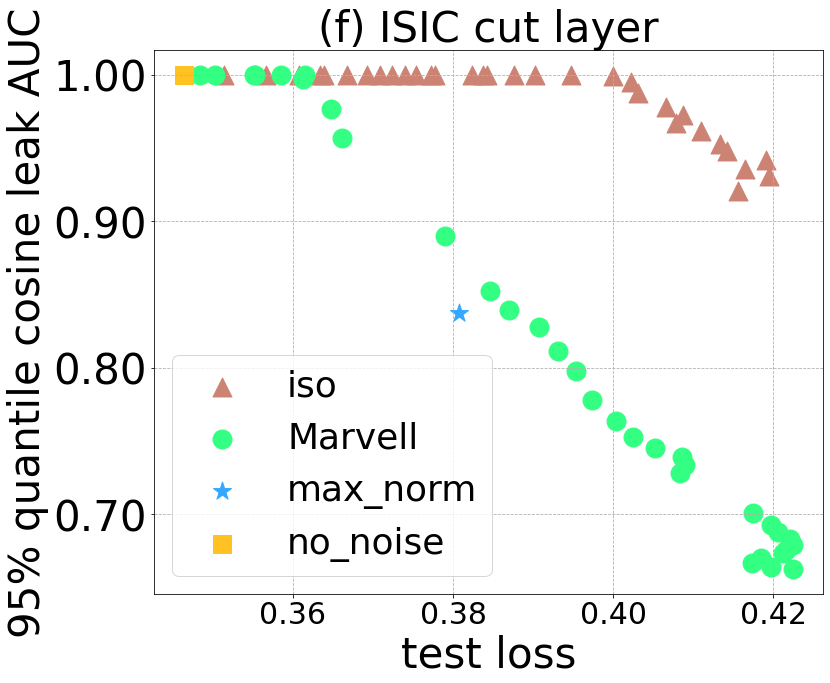

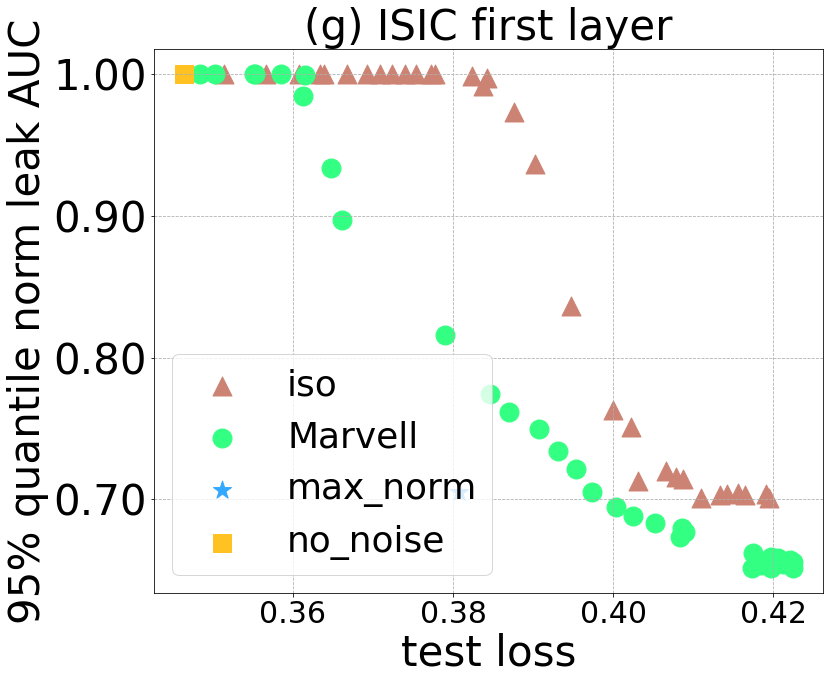

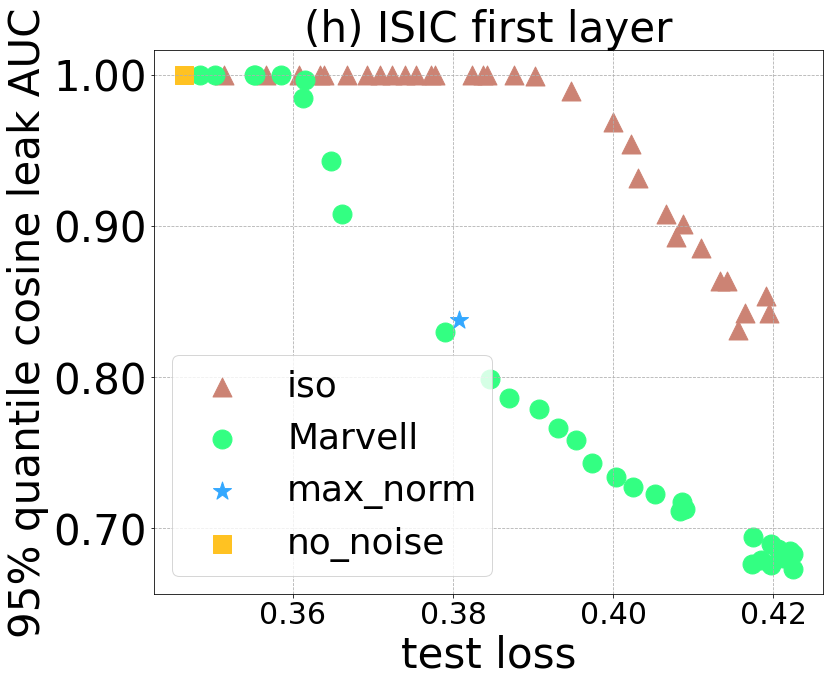

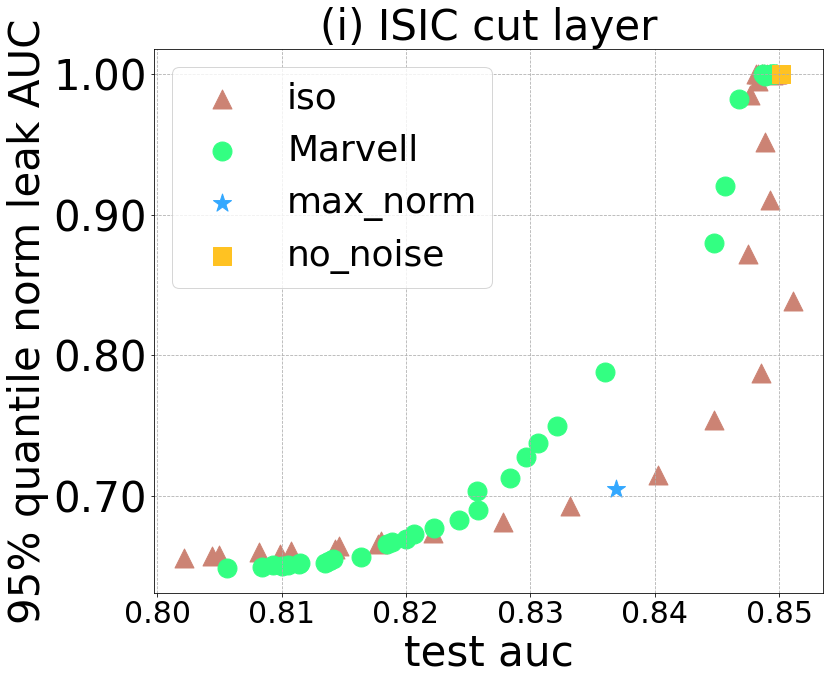

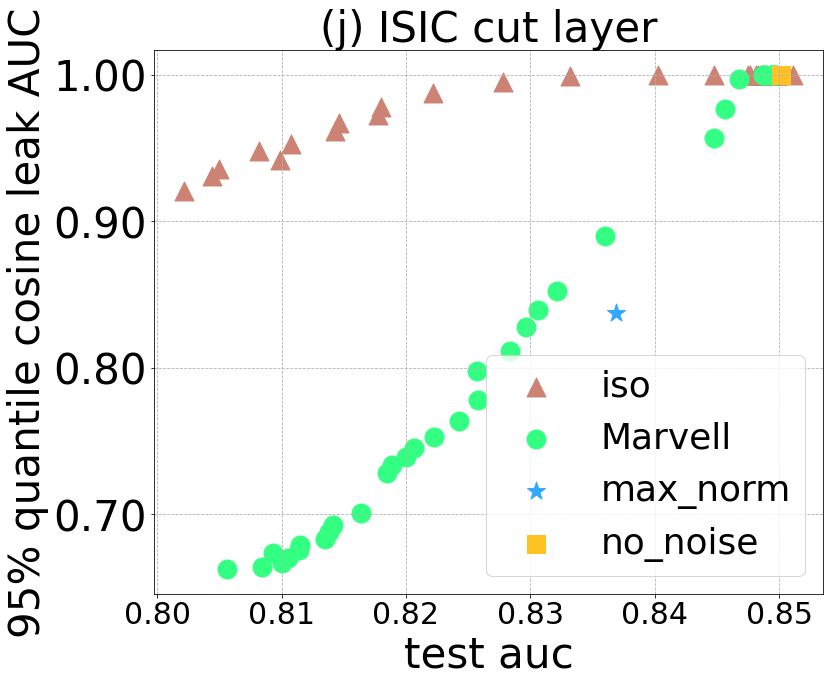

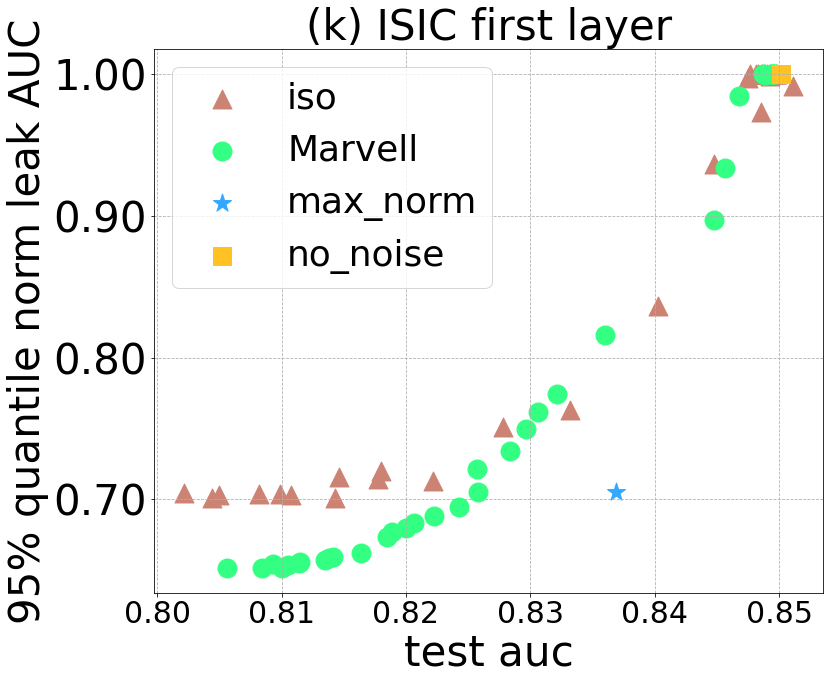

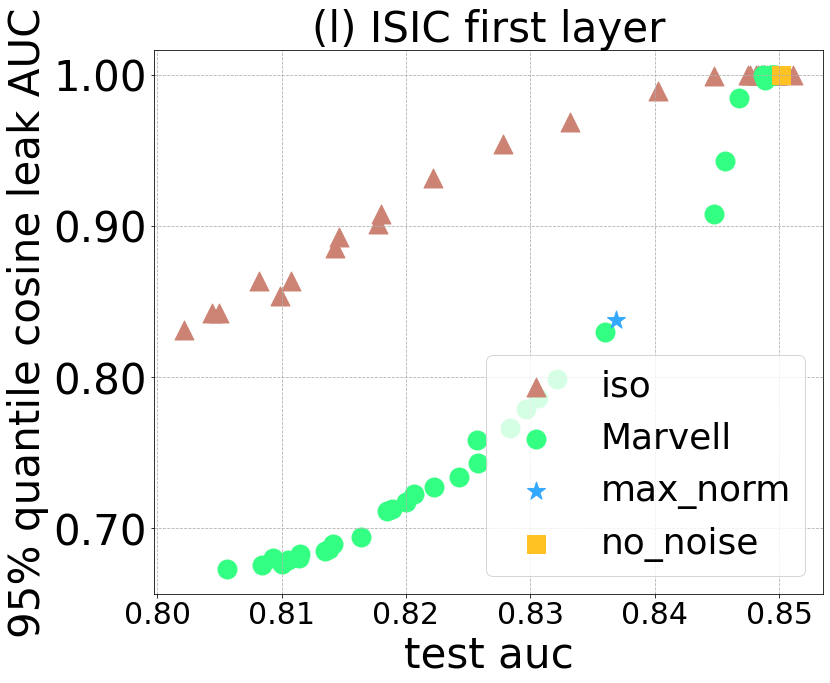

In [35]:
leak_tag_dict = {
    'norm_cut': 'mask_layer_4_conv64_norm_leak_batch',
    'norm_first': 'mask_layer_1_conv64_norm_leak_batch',
    'cosine_cut': 'mask_layer_4_conv64_cosine_leak_batch',
    'cosine_first': 'mask_layer_1_conv64_cosine_leak_batch'
}
perf_tag_list = ['train_loss', 'test_loss', 'test_auc']

# pair_list = [
#     ('test_loss', leak_tag_dict['norm_cut'], 'a'),
#     ('test_loss', leak_tag_dict['cosine_cut'], 'b'),
#     ('test_auc', leak_tag_dict['norm_cut'], 'e'),
#     ('test_auc', leak_tag_dict['cosine_cut'], 'f'),
#     ('test_auc', leak_tag_dict['norm_first'], 'i'),
#     ('test_auc', leak_tag_dict['cosine_first'], 'j'),
# ]

pair_list = [
    ('train_loss', leak_tag_dict['norm_cut'], 'a'),
    ('train_loss', leak_tag_dict['cosine_cut'], 'b'),
    ('train_loss', leak_tag_dict['norm_first'], 'c'),
    ('train_loss', leak_tag_dict['cosine_first'], 'd'),
    ('test_loss', leak_tag_dict['norm_cut'], 'e'),
    ('test_loss', leak_tag_dict['cosine_cut'], 'f'),
    ('test_loss', leak_tag_dict['norm_first'], 'g'),
    ('test_loss', leak_tag_dict['cosine_first'], 'h'),
    ('test_auc', leak_tag_dict['norm_cut'], 'i'),
    ('test_auc', leak_tag_dict['cosine_cut'], 'j'),
    ('test_auc', leak_tag_dict['norm_first'], 'k'),
    ('test_auc', leak_tag_dict['cosine_first'], 'l'),
]

for perf_tag, leak_tag, label in pair_list:
    if 'cosine' in leak_tag:
        ylabel = '95% quantile cosine leak AUC'
    else:
        ylabel = '95% quantile norm leak AUC'
    if perf_tag == 'test_auc':
        xlabel = 'test auc'
    elif perf_tag == 'test_loss':
        xlabel = 'test loss'
    elif perf_tag == 'train_loss':
        xlabel = 'train loss'
    else:
        assert False

    if 'mask_layer_4' in leak_tag:
        plot_title = 'ISIC cut layer'
    else:
        plot_title = 'ISIC first layer'

    scatter_plot_different_methods_tradeoff_curves(
            multiple_methods_info_dict=full_info_dict,
            leak_tag_name=leak_tag, # determines which layer's leak AUC to evaluate
            leak_mean_or_max='max', # use average of |leakAUC - 0.5| over all batches or use max over all batches
            performance_tag_name=perf_tag, # the performance metric (could be 'train_loss', 'test_auc')
            xlabel=xlabel,
            ylabel=ylabel,
            plot_title=f"({label}) " + plot_title,
            save_file_name=f"{label}_ISIC_{perf_tag}_{leak_tag}.pdf"
        )